# Sketch Classifier for "How Do Humans Sketch Objects?"

A sketch classifier using the dataset from the paper <a href='http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/'>How Do Humans Sketch Objects?</a> where the authors collected 20,000 unique sketches evenly distributed over 250 object categories - we will use a CNN (using Keras) to classify a sketch. 

<img src='http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/teaser_siggraph.jpg'/>

In [24]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
import os
import random 

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')

In [3]:
import keras 
keras.__version__

Using TensorFlow backend.


'2.0.8'

In [4]:
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import Input

from keras.utils import plot_model

from keras import preprocessing
from keras.preprocessing import image

## Trained on Floydhub

In [26]:
DEST_SKETCH_DIR = '/Users/Joshua.Newnham/Dropbox/Method - Personal/Machine Learning with CoreML/TrainingData/Chapter8/sketches/'
TARGET_SIZE = (256,256)
CATEGORIES_COUNT = 205
TRAINING_SAMPLES = 12736
VALIDATION_SAMPLES = 3184

In [6]:
!ls /sketches_training_data

training  validation


## Create model 

In [19]:
def plot_accuracy_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

More data always proves to be useful; exposing the network to more samples means that the model has a better chance of identifying and extracting the features that best *describe* a category. Images provide has an advantage over text in that we can easily modify it to expose the network to more samples, such as shifting the image around, rotating and flipping. This task is called *data augmentation* and Keras makes it easy, as shown below. For more information, check out the official Keras <a href='https://keras.io/preprocessing/image/'>documentation</a>. 

In [8]:
def train(model, 
          training_dir,
          validation_dir,
          target_size=TARGET_SIZE, 
          training_samples=TRAINING_SAMPLES, 
          validation_samples=VALIDATION_SAMPLES,
          epochs=1000, 
          batch_size=512, 
          load_previous_weights=True,
          model_weights_file=None):
    """
    
    """
    
    if model_weights_file is None:
        raise("No model weights file set")
    
    print("Training STARTED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    if model_weights_file is not None and os.path.isfile(model_weights_file) and load_previous_weights:
        print("Loading weights from file {}".format(model_weights_file))
        model.load_weights(model_weights_file)

    model.compile(
        loss='categorical_crossentropy', 
        optimizer='rmsprop', 
        metrics=['accuracy'])
    
    # create data generator 
    # check the official documentation for more details: https://keras.io/preprocessing/image/
    datagen = preprocessing.image.ImageDataGenerator(
        rescale=1./255., # rescaling factor applied by multiply the data by this value  
        width_shift_range=0.1, # ranges (as a fraction of total width) to randomly translate pictures 
        height_shift_range=0.1, # ranges (as a fraction of total height) to randomly translate pictures 
        zoom_range=0.1, # randomly zooming inside pictures
        horizontal_flip=True, # randomly flipping half of the images horizontally
        fill_mode='nearest') # strategy used for filling in newly created pixels
    
    if model.layers[0].input_shape[0] == target_size[0] and model.layers[0].input_shape[1] == target_size[1]:
        target_size = None
    
    # create an iterator for the training data 
    train_generator = datagen.flow_from_directory(
        training_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    # create an iterator for the validation data 
    validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    checkpoint = callbacks.ModelCheckpoint(model_weights_file, 
                                           monitor='val_loss', 
                                           verbose=0, 
                                           save_best_only=True, 
                                           save_weights_only=True, 
                                           mode='auto', 
                                           period=2)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    data_augmentation_multiplier = 1.5 
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=int((training_samples/batch_size) * data_augmentation_multiplier),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int((validation_samples/batch_size) * data_augmentation_multiplier), 
        callbacks=[checkpoint, early_stopping]) 
    
    print("Training FINISHED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    return history, model     

Inutitive we can see that, unlike photos, sketches don't have mine details but are better described by their strokes. This is how I had previously tackled the problem; using <a href='https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients'>Histogram of oriented gradients (HOG)</a> filters, I built a bag of visual words for each image. These 'visual words' were dominate gradients of each patch. We can replicate something similar using a ConvNet, but unlike my previous attempt, the feature engineering will be defined and refined during training using the lower layers of the network. 

In [6]:
def create_model(input_shape=(256,256,1), classes=CATEGORIES_COUNT, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(16, kernel_size=(7,7), strides=(3,3),  
                            padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu'))        
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(128, (5,5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(512, activation='relu', name='dense_2_512'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

In [10]:
model = create_model() 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 86, 86, 16)        800       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 64)        0         
__________

In [12]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(256,256),
                       epochs=1000, 
                       batch_size=512,
                       model_weights_file="/output/cnn_sketch_weights_2.h5", 
                       load_previous_weights=True)

Training STARTED - target size (256, 256), batch size 512
Found 13292 images belonging to 205 classes.
Found 3452 images belonging to 205 classes.
Epoch 1/1000
37/37 [==============================] - 144s - loss: 5.3332 - acc: 0.0049 - val_loss: 5.3218 - val_acc: 0.0087
Epoch 2/1000
37/37 [==============================] - 100s - loss: 5.3224 - acc: 0.0063 - val_loss: 5.3159 - val_acc: 0.0154
Epoch 3/1000
37/37 [==============================] - 100s - loss: 5.0805 - acc: 0.0229 - val_loss: 4.5121 - val_acc: 0.0753
Epoch 4/1000
37/37 [==============================] - 102s - loss: 4.7106 - acc: 0.0529 - val_loss: 4.1837 - val_acc: 0.1092
Epoch 5/1000
37/37 [==============================] - 101s - loss: 4.3798 - acc: 0.0888 - val_loss: 3.9764 - val_acc: 0.1529
Epoch 6/1000
37/37 [==============================] - 102s - loss: 4.1562 - acc: 0.1148 - val_loss: 3.7969 - val_acc: 0.1716
Epoch 7/1000
37/37 [==============================] - 100s - loss: 3.9421 - acc: 0.1490 - val_loss: 3.5

37/37 [==============================] - 100s - loss: 1.0175 - acc: 0.7048 - val_loss: 1.5846 - val_acc: 0.6244
Epoch 66/1000
37/37 [==============================] - 99s - loss: 1.0032 - acc: 0.7092 - val_loss: 1.5356 - val_acc: 0.6291
Epoch 67/1000
37/37 [==============================] - 102s - loss: 0.9778 - acc: 0.7124 - val_loss: 1.5638 - val_acc: 0.6244
Epoch 68/1000
37/37 [==============================] - 100s - loss: 0.9777 - acc: 0.7115 - val_loss: 1.5459 - val_acc: 0.6314
Epoch 69/1000
37/37 [==============================] - 101s - loss: 0.9728 - acc: 0.7163 - val_loss: 1.6262 - val_acc: 0.6144
Epoch 70/1000
37/37 [==============================] - 99s - loss: 0.9642 - acc: 0.7181 - val_loss: 1.6165 - val_acc: 0.6247
Epoch 71/1000
37/37 [==============================] - 101s - loss: 0.9269 - acc: 0.7254 - val_loss: 1.5588 - val_acc: 0.6392
Epoch 72/1000
37/37 [==============================] - 100s - loss: 0.9213 - acc: 0.7251 - val_loss: 1.5303 - val_acc: 0.6399
Epoch 73

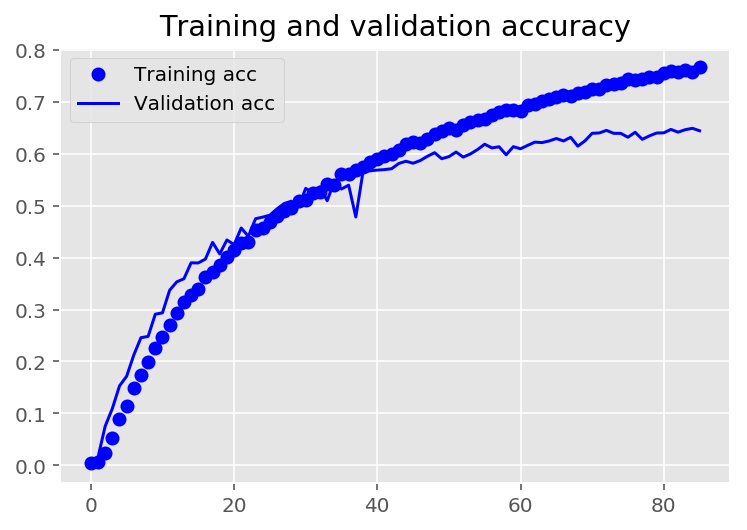

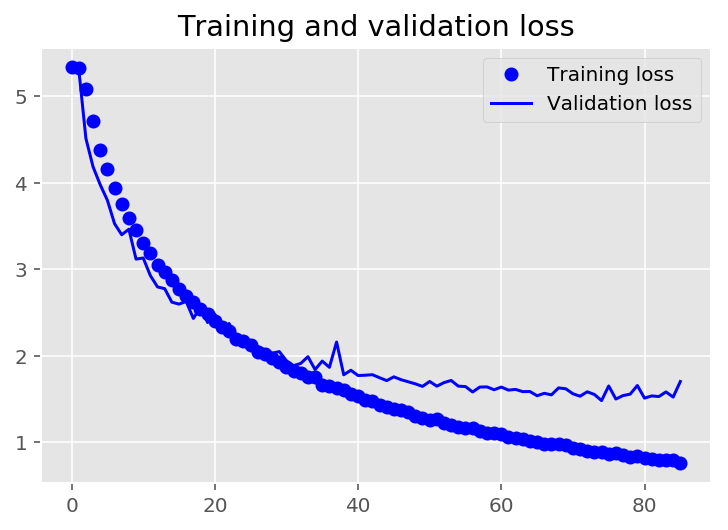

In [13]:
plot_accuracy_loss(history)

--- 

# CoreML

## Load (pretrained) model 

In [13]:
model = create_model() 
model.load_weights("output/cnn_sketch_weights_2.h5")

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 86, 86, 16)        800       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 43, 43, 32)        12832     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 10, 64)        0         
__________

In [44]:
def get_validation_metadata():
    """
    Walk the root directory and for each subdirectory, obtain the 
    list of .png image files creating (and returning) a list for each category label and 
    associated filepath 
    """
    image_file_paths = [] 
    categories = [] 
    labels = []
    
    validation_dir = os.path.join(DEST_SKETCH_DIR, 'validation')
    validation_directories = sorted(os.listdir(validation_dir))
    for d in validation_directories:                 
        
        if not os.path.isdir(os.path.join(validation_dir, d)):
            continue 
            
        labels.append(d) 
        label = d        
            
        for f in os.listdir(os.path.join(validation_dir, d)):
            full_path = os.path.join(os.path.join(validation_dir, d), f)            
            if os.path.isfile(full_path) and ".png" in full_path.lower():
                categories.append(label)
                image_file_paths.append(full_path)
    return labels, image_file_paths, categories

In [45]:
def make_predictions(model, categories, filepaths, labels, sample_idx, target_dimension=256.0):
    filename = filepaths[sample_idx]
    
    img = plt.imread(filename) # load image 
    
    scale = 1.0 
    # resize if size doesn't match the target dimension (assuming image is square)
    if img.shape[0] != target_dimension:
        scale = target_dimension / img.shape[0]
        img = imresize(img, scale)
        
    img = img[:,:,0] # take the single channel 
    img = img.reshape(1, int(target_dimension), int(target_dimension), 1)
    
    probs = model.predict(img)[0]
    predicted_index = np.argmax(probs)
    
    plt.imshow(imresize(plt.imread(filename), scale), 
               cmap='gray', 
               interpolation='nearest')
    
    plt.title("Pred: {} ({}%), Actual: {}".format(
        categories[predicted_index], 
        int(probs[predicted_index]*100),
        labels[sample_idx]))
    plt.tight_layout()
    plt.show() 
    
    return predicted_index

In [46]:
categories, validation_filepaths, labels = get_validation_metadata()

In [47]:
categories[0]

'airplane'

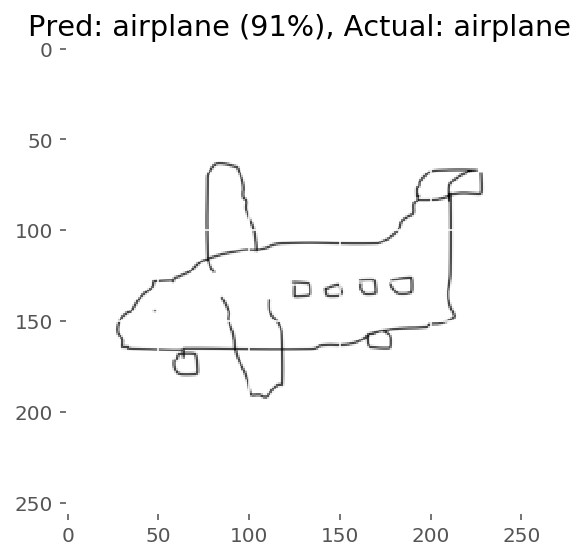

In [48]:
_ = make_predictions(model,
                     categories,
                     validation_filepaths, 
                     labels, 
                     random.randint(0,len(validation_filepaths) - 1))

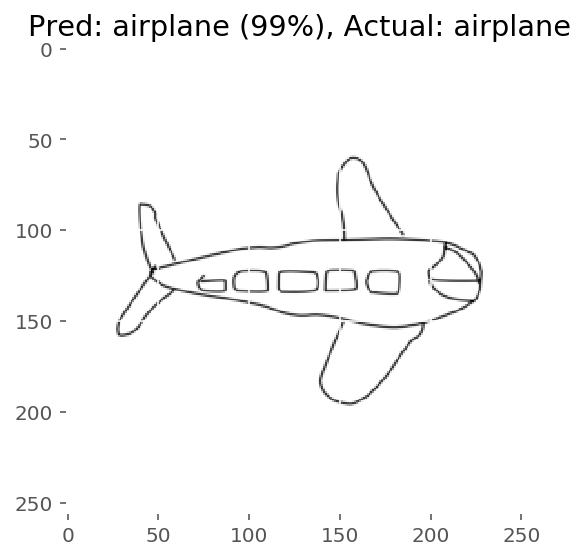

In [49]:
_ = make_predictions(model,
                     categories,
                     validation_filepaths, 
                     labels, 
                     0)

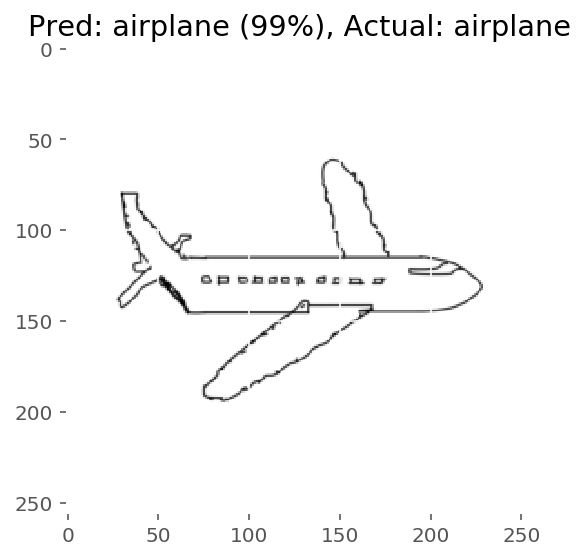

In [50]:
_ = make_predictions(model,
                     categories,
                     validation_filepaths, 
                     labels, 
                     10)

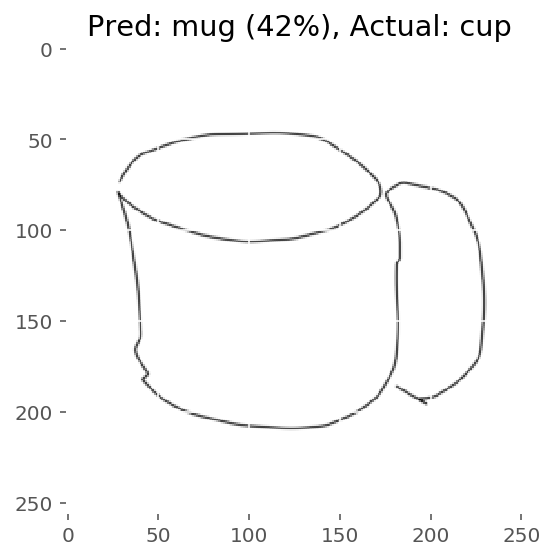

In [58]:
_ = make_predictions(model,
                     categories,
                     validation_filepaths, 
                     labels, 
                     1000)

### Confusion matrix 

One way to evaluate the quality of your classifier (especially for multi-class) is visualising a confusion matrix. The diagonal elements represent the number of point for which the predicted label is equal to the true label, while the off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix, the better the model is performing i.e. we should see a dark line diagonally along the plot. 

In [61]:
def plot_confusion_matrix(model, categories, filepaths, labels, 
                          target_dimension=256.0, normalize=False, cmap=plt.cm.Blues):
    from sklearn.metrics import confusion_matrix
    
    y_true = [] 
    y_pred = [] 
    
    category_2_idx = {category:idx for idx, category in enumerate(categories)}
    idx_2_category = {idx:category for idx, category in enumerate(categories)}
    
    for idx, filename in enumerate(filepaths): 
        img = plt.imread(filename) # load image 
    
        scale = 1.0 
        # resize if size doesn't match the target dimension (assuming image is square)
        if img.shape[0] != target_dimension:
            scale = target_dimension / img.shape[0]
            img = imresize(img, scale)
        
        img = img[:,:,0] # take the single channel 
        img = img.reshape(1, int(target_dimension), int(target_dimension), 1)
    
        probs = model.predict(img)[0]
        predicted_index = np.argmax(probs)        
        actual_index = category_2_idx[labels[idx]] 
        
        y_true.append(labels[idx])
        y_pred.append(idx_2_category[predicted_index])
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
        
    cnf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=categories)
    
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 12))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    #tick_marks = np.arange(len(categories))
    #plt.xticks(tick_marks, categories, rotation=45)
    #plt.yticks(tick_marks, categories)
    #plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

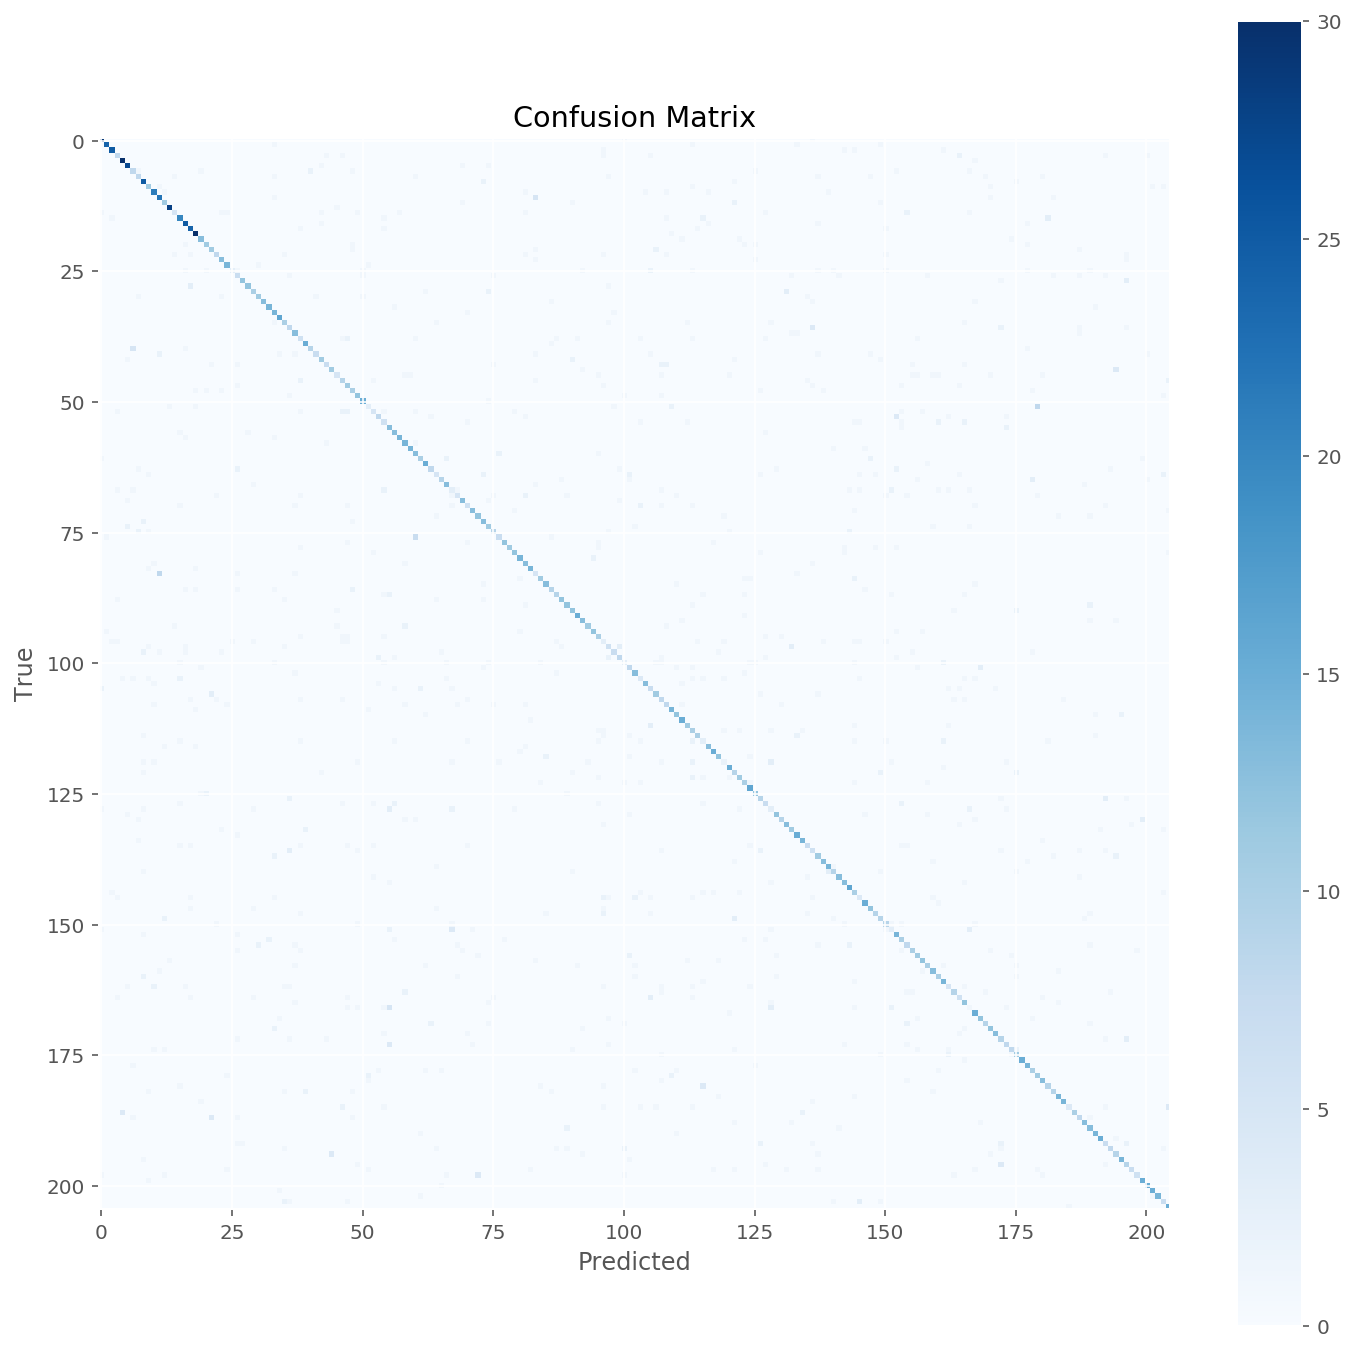

In [62]:
plot_confusion_matrix(model, 
                      categories, 
                      validation_filepaths, 
                      labels)

## Create CoreML model 

In [63]:
import coremltools

In [64]:
coreml_model = coremltools.converters.keras.convert(model, 
                                                    input_names=['image'], 
                                                    image_input_names=['image'], 
                                                    output_names=['classLabelProbs'],
                                                    class_labels=categories)

0 : conv2d_9_input, <keras.engine.topology.InputLayer object at 0x120aac850>
1 : conv2d_9, <keras.layers.convolutional.Conv2D object at 0x120aac810>
2 : conv2d_9__activation__, <keras.layers.core.Activation object at 0x128026b90>
3 : max_pooling2d_9, <keras.layers.pooling.MaxPooling2D object at 0x120b06250>
4 : conv2d_10, <keras.layers.convolutional.Conv2D object at 0x120aacb10>
5 : conv2d_10__activation__, <keras.layers.core.Activation object at 0x128445ed0>
6 : max_pooling2d_10, <keras.layers.pooling.MaxPooling2D object at 0x120aacb90>
7 : conv2d_11, <keras.layers.convolutional.Conv2D object at 0x120aacd50>
8 : conv2d_11__activation__, <keras.layers.core.Activation object at 0x128445fd0>
9 : max_pooling2d_11, <keras.layers.pooling.MaxPooling2D object at 0x120ac47d0>
10 : conv2d_12, <keras.layers.convolutional.Conv2D object at 0x120ae3e10>
11 : conv2d_12__activation__, <keras.layers.core.Activation object at 0x128019090>
12 : max_pooling2d_12, <keras.layers.pooling.MaxPooling2D object

In [65]:
def test_coreml(coreml_model, 
                         categories, 
                         filepaths, 
                         labels, 
                         sample_idx, 
                         target_dimension=256):
    
    from PIL import Image  
    
    filename = filepaths[sample_idx]
    
    # load image
    img = Image.open(filename).convert('L')  
    
    # resize if size doesn't match the target dimension (assuming image is square)    
    scale = 1.0 
    if img.size[0] != target_dimension:
        scale = target_dimension / img.size[0]
        img = imresize(img, scale)
    
    results = coreml_model.predict({'image':img})
    predicted_label = results['classLabel']
    predicted_prob = results['classLabelProbs'][predicted_label]
    
    true_label = labels[sample_idx]
    
    plt.imshow(imresize(plt.imread(filename), scale), 
               cmap='gray', 
               interpolation='nearest')    
    
    plt.title("Pred: {} ({}%), Actual: {}".format(
        predicted_label, 
        int(predicted_prob*100),
        true_label))
    plt.tight_layout()
    plt.show() 
    

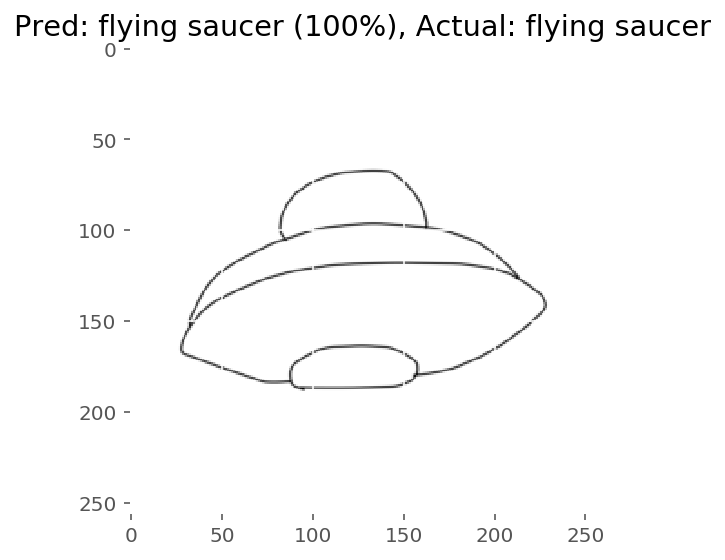

In [67]:
test_coreml(coreml_model, 
            categories,
            validation_filepaths, 
            labels, 
            random.randint(0, len(validation_filepaths)-1))

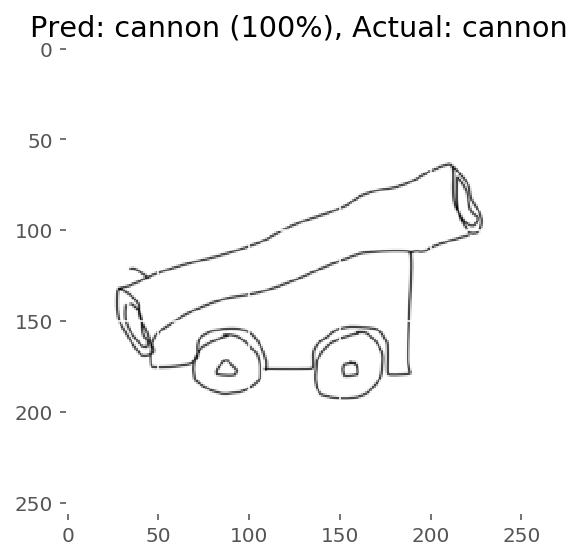

In [68]:
test_coreml(coreml_model, 
            categories,
            validation_filepaths, 
            labels, 
            random.randint(0, len(validation_filepaths)-1))

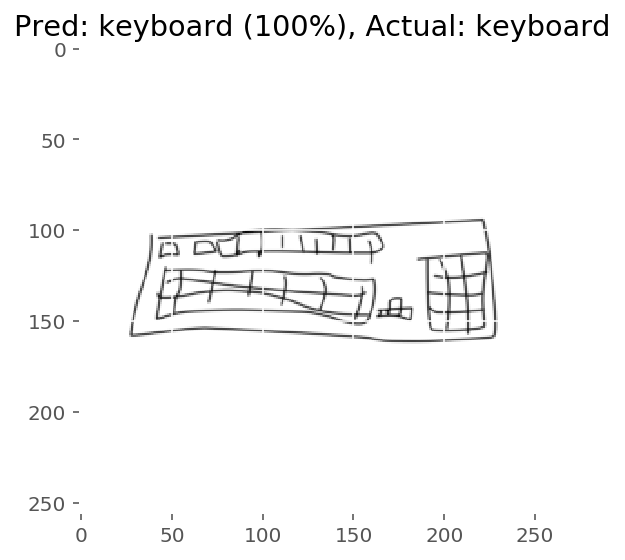

In [72]:
test_coreml(coreml_model, 
            categories,
            validation_filepaths, 
            labels, 
            random.randint(0, len(validation_filepaths)-1))

### CoreML model metadata

In [73]:
coreml_model.author = 'Joshua Newnham'
coreml_model.license = 'BSD'
coreml_model.short_description = 'Freehand sketch recognizer trained using the dataset from the paper How Do Humans Sketch Objects? consisting of 250 categories using a total of 20k examples'
coreml_model.input_description['image'] = 'Input sketch (grayscale image) to be classified'
coreml_model.output_description['classLabelProbs'] = 'Probability of each category'
coreml_model.output_description['classLabel'] = 'Most likely sketch category'

### Save CoreML model and labels

In [74]:
coreml_model.save('output/cnnsketchclassifier.mlmodel')

In [75]:
with open('output/sketch_classes.csv', 'w') as f:
    for idx, category in enumerate(categories):
        f.write("{},{}\n".format(idx, category))

# Visual Similarity

Previously we created a model to classify a given sketch; in this part we want to make use of this model to find similar images - how? Currently our model outputs a probability distribution across the 250 classes (we take the max probability as the predicted class) but we can also use this model to find similar images simply by inspecting and comparing the activations of the higher layers; either taking the layer above the output or layer above this. Let's but this idea to practice.  

In [76]:
model = create_model() 
model.load_weights("output/cnn_sketch_weights_2.h5")

In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 86, 86, 16)        800       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 43, 43, 32)        12832     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 10, 64)        0         
__________

In [78]:
model.layers.pop()

**Remove last layer**

In [79]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 86, 86, 16)        800       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 43, 43, 32)        12832     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 10, 64)        0         
__________

We next have to create a model; updating it's input and outputs to reflect the changes above i.e. assigning our last layer (above) as the output of our model. 

In [80]:
from keras.models import Model

model_input = model.input
model_output = model.layers[-1].output

model = Model(model_input, model_output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13_input (InputLayer) (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 86, 86, 16)        800       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 43, 43, 32)        12832     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 10, 10, 64)        0         
__________

In [81]:
def get_activations(model, filename, flip=False, target_dimension=256.0):
    img = plt.imread(filename) # load image 
    
    scale = 1.0 
    # resize if size doesn't match the target dimension (assuming image is square)
    if img.shape[0] != target_dimension:
        scale = target_dimension / img.shape[0]
        img = imresize(img, scale)
        
    img = img[:,:,0] # take the single channel 
    img = img.reshape(1, int(target_dimension), int(target_dimension), 1)
    
    if flip:
        img = np.fliplr(img)
    
    probs = model.predict(img)[0]

    return probs 

In [82]:
def plot_image(categories, filepaths, labels, sample_idx, flip=False, target_dimension=256.0):
    filename = filepaths[sample_idx]
    
    img = plt.imread(filename) # load image 
    
    scale = 1.0 
    # resize if size doesn't match the target dimension (assuming image is square)
    if img.shape[0] != target_dimension:
        scale = target_dimension / img.shape[0]
        img = imresize(img, scale)
        
    img = img[:,:,0] # take the single channel 
    img = img.reshape(1, int(target_dimension), int(target_dimension), 1)
        
    plt.imshow(imresize(plt.imread(filename), scale), 
               cmap='gray', 
               interpolation='nearest')
    
    plt.title("{}".format(
        labels[sample_idx]))
    plt.tight_layout()
    plt.show() 

In [83]:
categories, validation_filepaths, labels = get_validation_metadata()

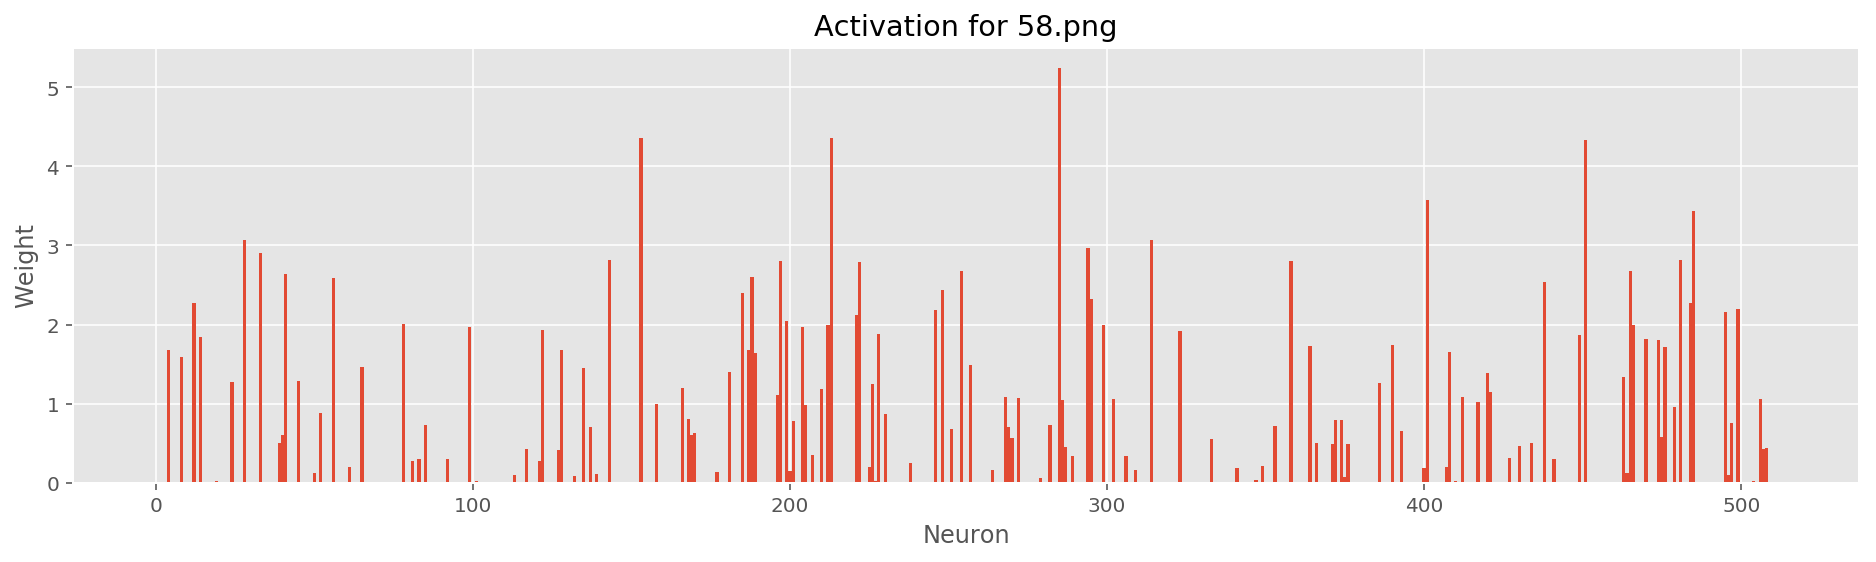

In [90]:
plt.figure(figsize=(16,4))
plt.bar(np.arange(512), get_activations(model, validation_filepaths[0]), width=1)
plt.title('Activation for {}'.format(
    os.path.split(validation_filepaths[10])[-1]))
plt.xlabel('Neuron')
plt.ylabel('Weight')

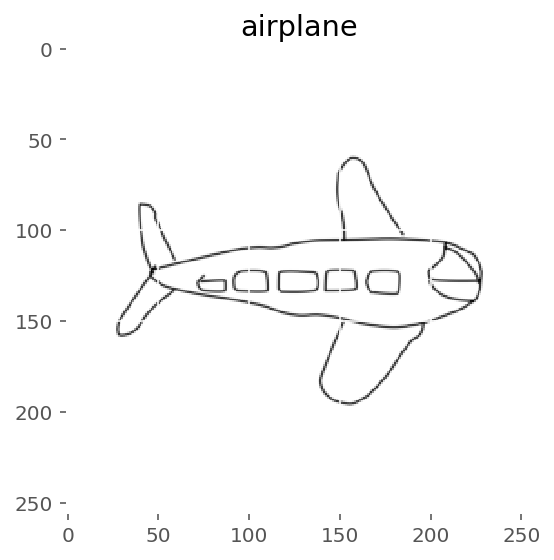

In [91]:
plot_image(categories, validation_filepaths, labels, 0)

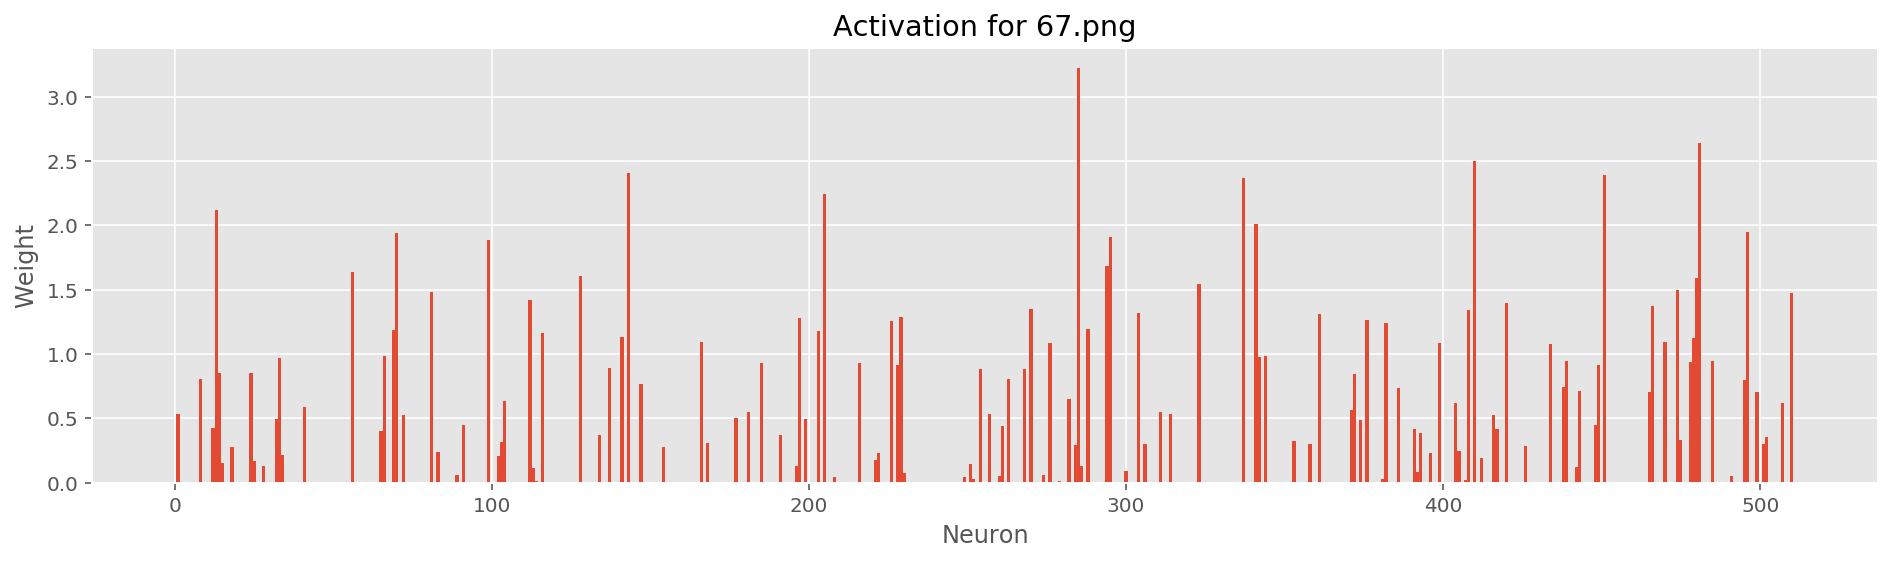

In [92]:
plt.figure(figsize=(16,4))
plt.bar(np.arange(512), get_activations(model, validation_filepaths[1]), width=1)
plt.title('Activation for {}'.format(
    os.path.split(validation_filepaths[11])[-1]))
plt.xlabel('Neuron')
plt.ylabel('Weight')

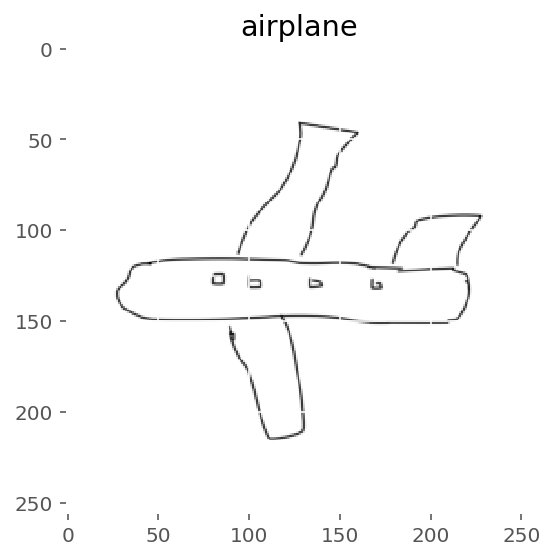

In [93]:
plot_image(categories, validation_filepaths, labels, 1)

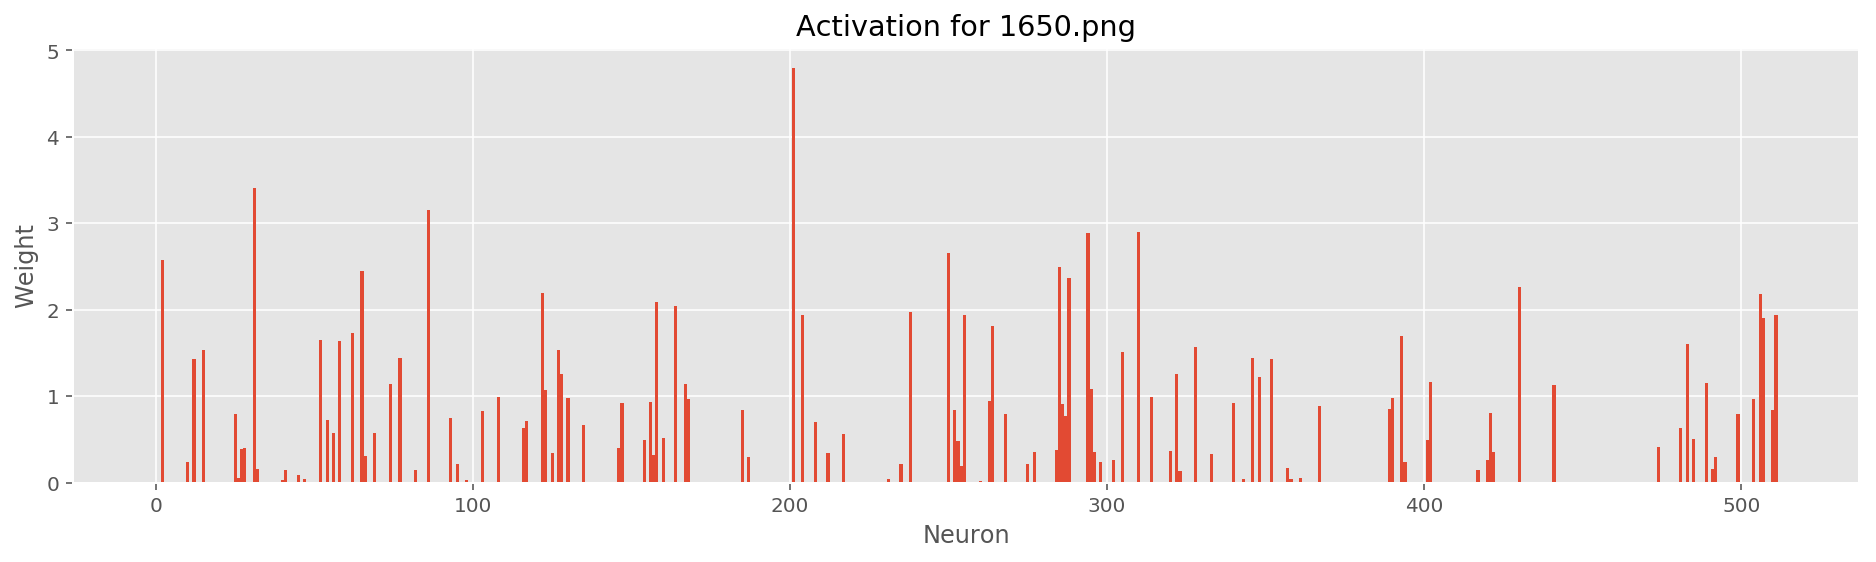

In [101]:
plt.figure(figsize=(16,4))
plt.bar(np.arange(512), get_activations(model, validation_filepaths[400]), width=1)
plt.title('Activation for {}'.format(
    os.path.split(validation_filepaths[501])[-1]))
plt.xlabel('Neuron')
plt.ylabel('Weight')

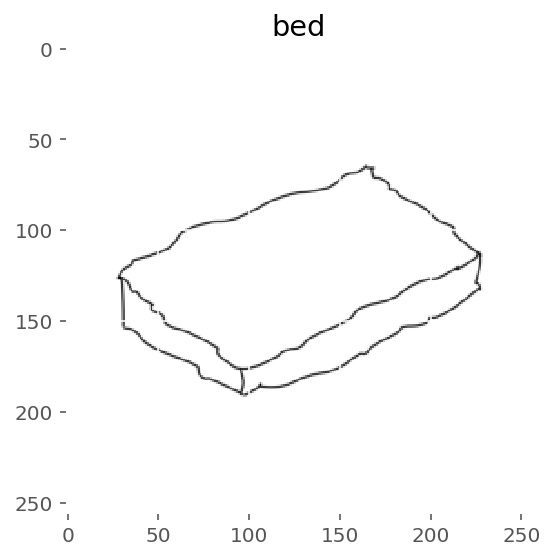

In [100]:
plot_image(categories, validation_filepaths, labels, 400)

### Calculate and compare the cosine distance between airplanes 0, 1, and 2

In [103]:
def calc_cosine(a, b):
    from scipy.spatial.distance import cosine
    return cosine(a, b)

In [108]:
print(calc_cosine(
    get_activations(model, validation_filepaths[0]).tolist(), 
    get_activations(model, validation_filepaths[0]).tolist()))

1.11022302463e-16


In [109]:
print(calc_cosine(
    get_activations(model, validation_filepaths[0]).tolist(), 
    get_activations(model, validation_filepaths[1]).tolist()))

0.469884764798


In [111]:
print(calc_cosine(
    get_activations(model, validation_filepaths[0]).tolist(), 
    get_activations(model, validation_filepaths[400]).tolist()))

0.717478500349


In [112]:
print(calc_cosine(
    get_activations(model, validation_filepaths[0]).tolist(), 
    get_activations(model, validation_filepaths[0], flip=True).tolist()))

0.163706726993


## Create CoreML model 

In [113]:
import coremltools

In [114]:
coreml_model = coremltools.converters.keras.convert(model, 
                                                    input_names=['image'], 
                                                    image_input_names=['image'],
                                                    output_names=['classActivations'])

0 : conv2d_13_input, <keras.engine.topology.InputLayer object at 0x1284b4c10>
1 : conv2d_13, <keras.layers.convolutional.Conv2D object at 0x1284b4410>
2 : conv2d_13__activation__, <keras.layers.core.Activation object at 0x13af41950>
3 : max_pooling2d_13, <keras.layers.pooling.MaxPooling2D object at 0x1284b4c50>
4 : conv2d_14, <keras.layers.convolutional.Conv2D object at 0x1284b4fd0>
5 : conv2d_14__activation__, <keras.layers.core.Activation object at 0x13af41b50>
6 : max_pooling2d_14, <keras.layers.pooling.MaxPooling2D object at 0x1274d5f10>
7 : conv2d_15, <keras.layers.convolutional.Conv2D object at 0x127939b10>
8 : conv2d_15__activation__, <keras.layers.core.Activation object at 0x13af41c90>
9 : max_pooling2d_15, <keras.layers.pooling.MaxPooling2D object at 0x1216c3b90>
10 : conv2d_16, <keras.layers.convolutional.Conv2D object at 0x1216ce1d0>
11 : conv2d_16__activation__, <keras.layers.core.Activation object at 0x13af412d0>
12 : max_pooling2d_16, <keras.layers.pooling.MaxPooling2D ob

In [115]:
coreml_model.input_description

Features(image)

In [116]:
coreml_model.output_description

Features(classActivations)

In [117]:
coreml_model.author = 'Joshua Newnham'
coreml_model.license = 'BSD'
coreml_model.short_description = 'Based on the freehand sketch recognizer, trained using the dataset from the paper How Do Humans Sketch Objects? consisting of 250 categories using a total of 20k examples, but instead of classifying this model returns the activations of the last layer for visual similarity matching'
coreml_model.input_description['image'] = 'Input sketch (grayscale image) to be processed'
coreml_model.output_description['classActivations'] = 'Activations for a given image'

In [118]:
coreml_model.save('output/cnnsketchfeatureextractor.mlmodel')